# Model Performance

In [37]:
# load libraries
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import yfinance as yf
from numerapi import NumerAPI
from utils.api_keys import PUBLIC_ID, SECRET_KEY

In [2]:
# instantiate
TODAY = dt.datetime.now()
nmr = yf.download('NMR-USD', start=TODAY, end=TODAY)
napi = NumerAPI(public_id=PUBLIC_ID, secret_key=SECRET_KEY)

[*********************100%***********************]  1 of 1 completed


In [81]:
# get model performance history
def get_model_rankings(model_list):
    df_list = []
    for m in model_list:
        df = pd.DataFrame.from_dict(napi.daily_model_performances(m))
        df['modelName'] = m
        df_list.append( df)
    df_all = pd.concat(df_list).set_index("date")
    return df_all

# plot model rankings
def plot_model_rankings(data, after_date, cols):
    fig, axes = plt.subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(12, 5))
    data.loc[data["modelName"] == "dh_foxhound", cols][after_date:].plot(ax=axes[0])
    data.loc[data["modelName"] == "dh_deadcell", cols][after_date:].plot(ax=axes[1])
    data.loc[data["modelName"] == "dh_desperado", cols][after_date:].plot(ax=axes[2])
    axes[0].set_title("Foxhound")
    axes[1].set_title("Deadcell")
    axes[2].set_title("Desperado")
    plt.show()

# Current Staking Amount

In [4]:
# nmr price
nmr_price = nmr[['Open', 'High', 'Low', 'Close']].mean(axis=1)[0]
nmr_price

23.7101092338562

In [5]:
# get model names
model_list = napi.get_models().keys()
model_list

dict_keys(['dh_foxhound', 'dh_deadcell', 'dh_cobra', 'dh_beautybeast', 'dh_skulls', 'dh_desperado'])

In [6]:
# get current staking amount
for k in model_list:
    try:
        nmr_stake = round(float(napi.stake_get(k)), 2)
        nmr_usd = round(nmr_stake * nmr_price, 2)
        print(f"{k}: NMR{nmr_stake}, ${nmr_usd}")
    except:
        pass

dh_foxhound: NMR1.03, $24.42
dh_deadcell: NMR1.01, $23.95
dh_desperado: NMR0.0, $0.0


# Model Ranks

In [7]:
# get model rankings
perf = get_model_rankings(model_list=model_list)
perf.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 319 entries, 2022-04-29 00:00:00+00:00 to 2022-04-29 00:00:00+00:00
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   corrRank   319 non-null    float64
 1   corrRep    319 non-null    float64
 2   fncRank    319 non-null    float64
 3   fncRep     319 non-null    float64
 4   fncV3Rank  27 non-null     float64
 5   fncV3Rep   27 non-null     float64
 6   mmcRank    319 non-null    float64
 7   mmcRep     319 non-null    float64
 8   tcRank     112 non-null    float64
 9   tcRep      112 non-null    float64
 10  modelName  319 non-null    object 
dtypes: float64(10), object(1)
memory usage: 29.9+ KB


In [82]:
# date variable
AFTER_DATE = "2022-04-01"

In [83]:
# cols
rank_cols = [col for col in perf.columns if col.endswith("Rank")]
rep_cols = [col for col in perf.columns if col.endswith("Rep")]

rank_cols, rep_cols

(['corrRank', 'fncRank', 'fncV3Rank', 'mmcRank', 'tcRank'],
 ['corrRep', 'fncRep', 'fncV3Rep', 'mmcRep', 'tcRep'])

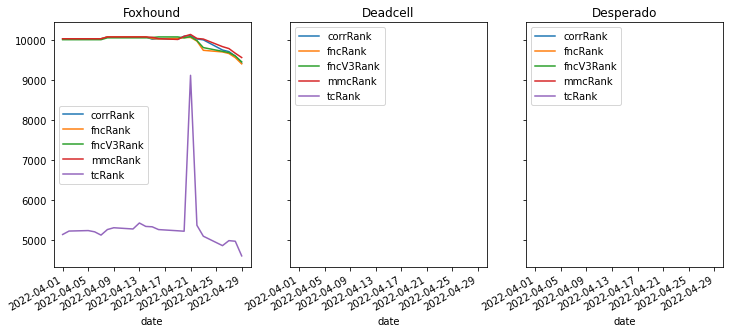

In [84]:
# plot rankings
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=rank_cols)

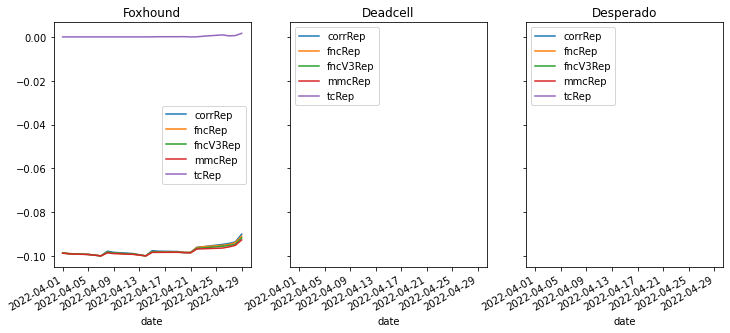

In [85]:
# plot reputations
plot_model_rankings(data=perf, after_date=AFTER_DATE, cols=rep_cols)